In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ugradio
import astropy.coordinates
import astropy.time
import time
import astropy.io.fits as fits

In [2]:
data_noise_on = []
data_noise_off = []

In [3]:
data_noise_off_example = fits.open('../Data/celestial_pole-noiseoff_' + str(0) + '.fits')

In [4]:
for i in range(0, 386):
    d_off_avg = []
    d_on_avg = []
    for j in range(1, 21):
        d_off = fits.open('../Data/celestial_pole-noiseoff_' + str(i) + '.fits')
        d_off = d_off[j].data['auto0_real']
        d_off_avg.append(d_off)
    d_off_avg = np.mean(d_off_avg, axis=0)
    data_noise_off.append(d_off_avg)
    
    for k in range(1, 3):
        d_on = fits.open('../Data/celestial_pole-noiseon_' + str(i) + '.fits')[k].data['auto0_real']
        d_on_avg.append(d_on)
    d_on_avg = np.mean(d_on_avg, axis=0)
    data_noise_on.append(d_on_avg)

In [5]:
hdr = dict(data_noise_off_example[0].header)
if_freq = 144 + np.arange(0, hdr['NCHAN']) * hdr['RES'] / 1e6
rf_freq = if_freq + 2*635

# this is wrong and stupid
data_noise_on_average = np.mean(data_noise_on, axis=0)
data_noise_off_average = np.mean(data_noise_off, axis=0)

<IPython.core.display.Javascript object>


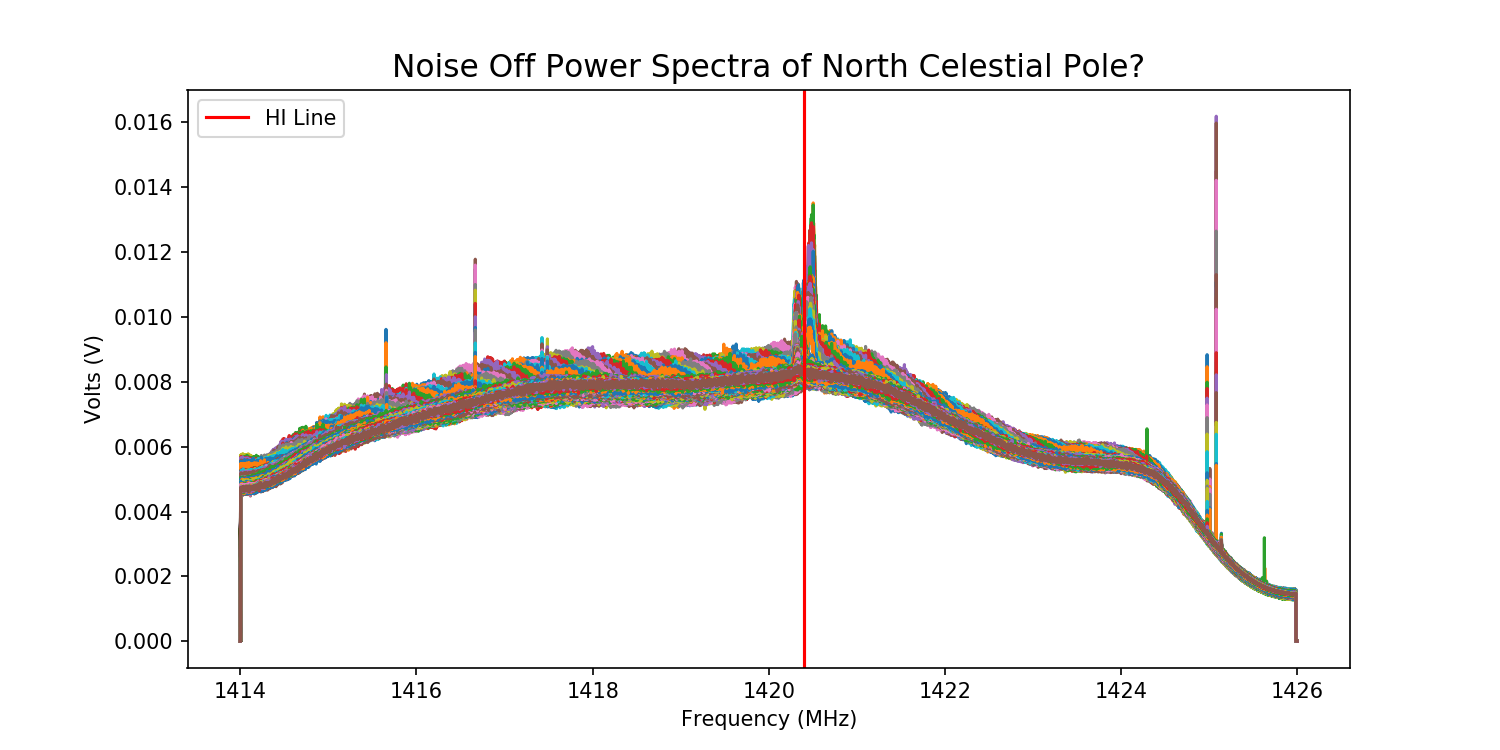

In [6]:
%matplotlib notebook
plt.figure(figsize=(10,5))

for i in range(0,386):
    
    #plt.plot(rf_freq, data_noise_on[i], label='ON')
    plt.plot(rf_freq, data_noise_off[i])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='r', label='HI Line')
plt.title('Noise Off Power Spectra of North Celestial Pole?', fontsize=15)
plt.legend()

#redshifted 

<IPython.core.display.Javascript object>


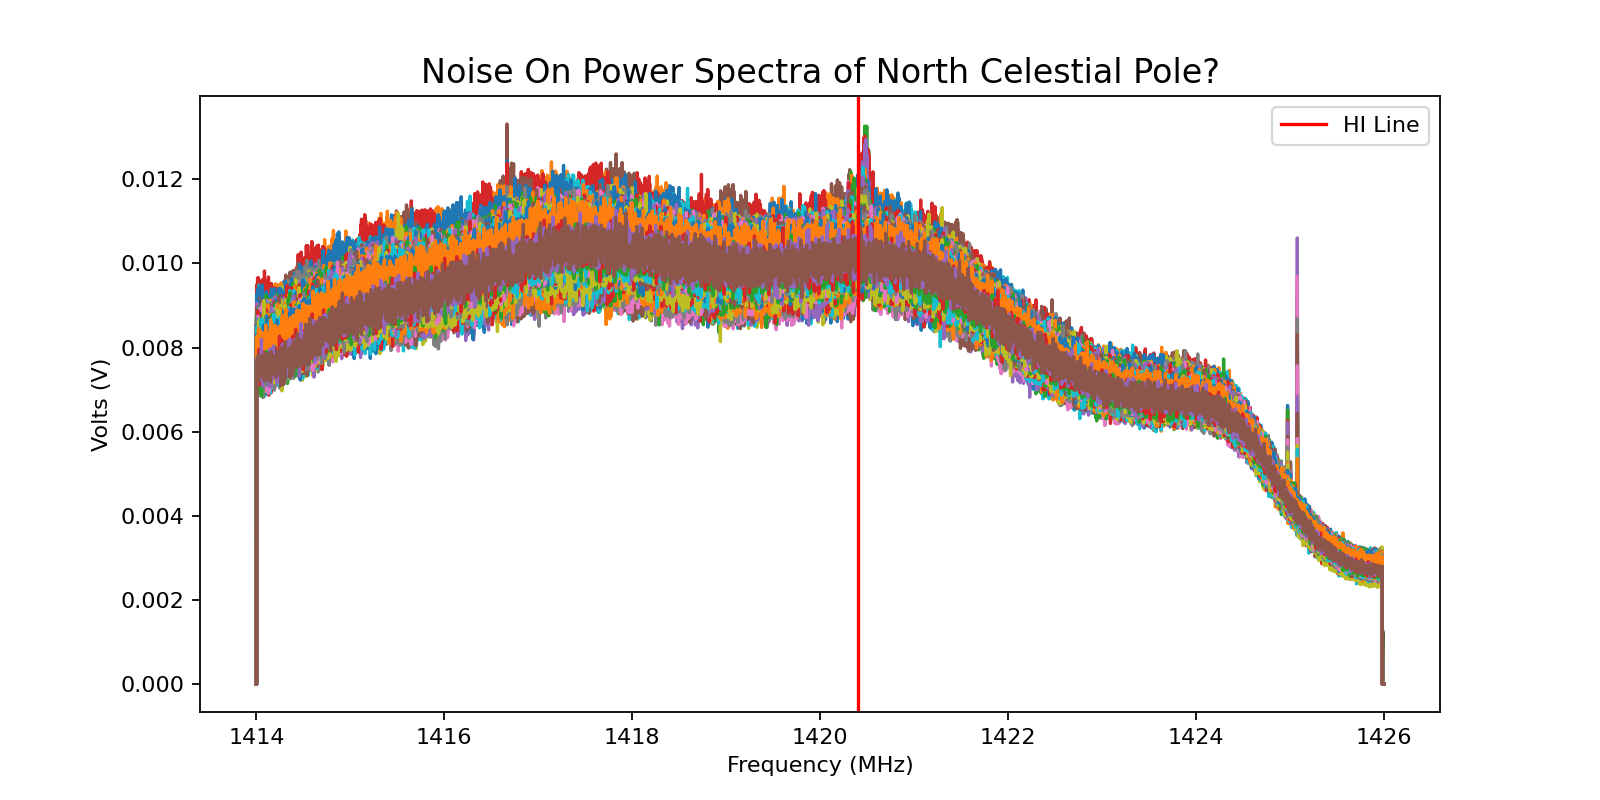

In [11]:
%matplotlib notebook
plt.figure(figsize=(10,5))

for i in range(0,386):
    
    plt.plot(rf_freq, data_noise_on[i])
    #plt.plot(rf_freq, data_noise_off[i])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='r', label='HI Line')
plt.title('Noise On Power Spectra of North Celestial Pole?', fontsize=15)
plt.legend()

#redshifted 

# Calibration 

In [7]:
import tqdm 

In [8]:
data_noise_on[i].shape[0]

8192

<IPython.core.display.Javascript object>


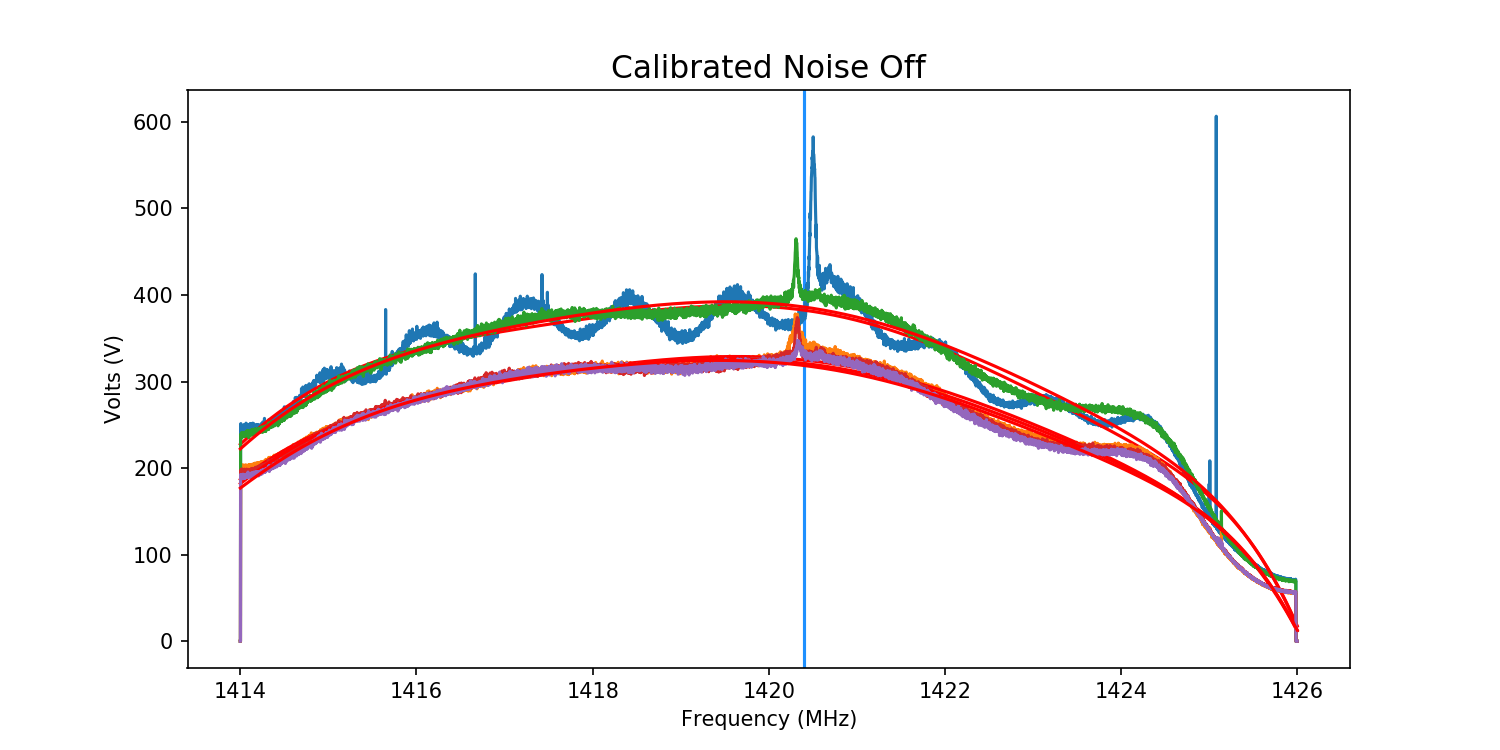

100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 113.46it/s]


In [9]:
# are these values correct?
t_noise = 90
t_sys = 2.5

%matplotlib notebook
plt.figure(figsize=(10,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Volts (V)')
plt.axvline(1420.405, color='dodgerblue', label='HI Line')
plt.title('Calibrated Noise Off', fontsize=15)

for i in tqdm.tqdm(range(0, 386, 80)):
    
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg
    
    p = np.polyfit(np.arange(np.array(s_line).shape[0]), s_line, 7)
    
    fit = np.polyval(p, np.arange(np.array(data_noise_off[i]).shape[0]))
    
    plt.plot(rf_freq, g*(s_line), label='ON') #off

    plt.plot(rf_freq, g*fit, "r")

In [11]:
calibrated_noise_off_spectra = []

<IPython.core.display.Javascript object>


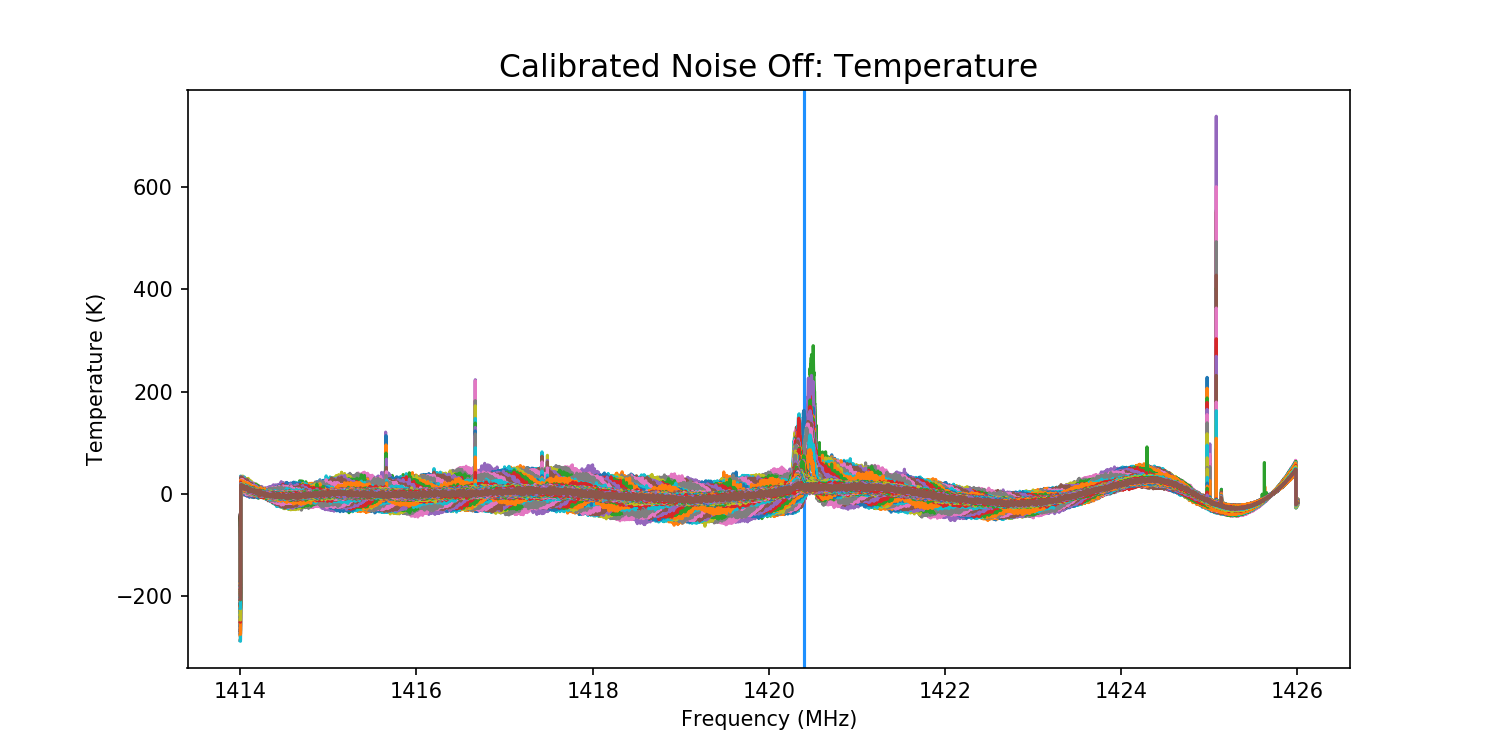

100%|███████████████████████████████████████████████████████████████████████████████| 386/386 [00:01<00:00, 325.58it/s]


In [12]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
plt.axvline(1420.405, color='dodgerblue', label='HI Line')
plt.title('Calibrated Noise Off: Temperature', fontsize=15)

for i in tqdm.tqdm(range(0, 386)):
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg
    
    p = np.polyfit(np.arange(np.array(s_line).shape[0]), s_line, 7)
    
    fit = np.polyval(p, np.arange(np.array(data_noise_off[i]).shape[0]))
    
    plt.plot(rf_freq, g*(s_line - fit), label='ON') #off
    
    calibrated_noise_off_spectra.append(g*(s_line - fit))

<IPython.core.display.Javascript object>


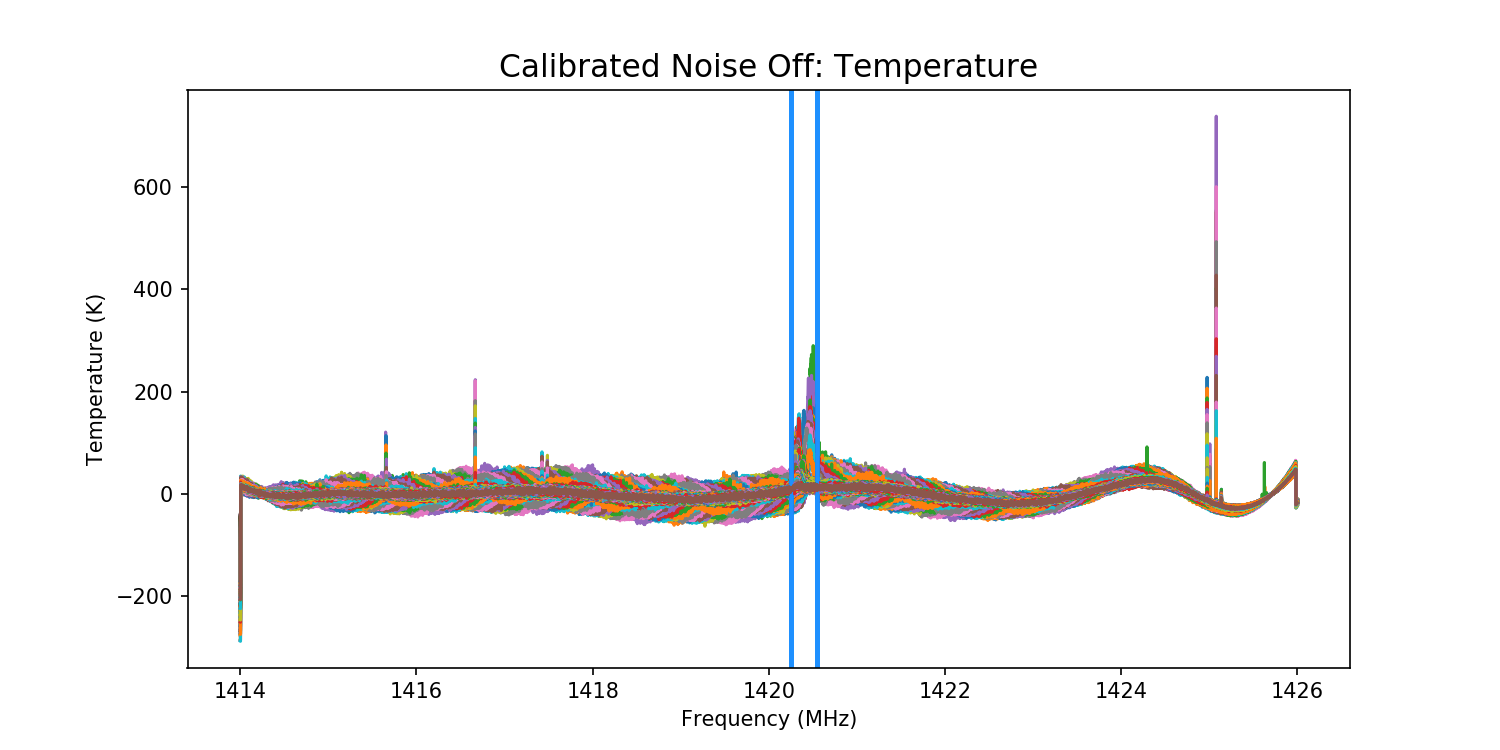

100%|███████████████████████████████████████████████████████████████████████████████| 386/386 [00:02<00:00, 169.49it/s]


In [45]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.xlabel('Frequency (MHz)')
plt.ylabel('Temperature (K)')
plt.title('Calibrated Noise Off: Temperature', fontsize=15)

for i in tqdm.tqdm(range(0, 386)):
    g = (t_noise - t_sys) / np.sum(data_noise_on[i] - data_noise_off[i]) * np.sum(data_noise_on[i])

    s_line = data_noise_off[i]/(np.mean(data_noise_off[i][3000:4000])) #~8000 data points, don't include peak in avg
    
    p = np.polyfit(np.arange(np.array(s_line).shape[0]), s_line, 7)
    
    fit = np.polyval(p, np.arange(np.array(data_noise_off[i]).shape[0]))
    
    plt.axvline(rf_freq[4270], color='dodgerblue')
    plt.axvline(rf_freq[4470], color='dodgerblue')
    
    plt.plot(rf_freq, g*(s_line - fit), label='ON') #off

In [13]:
#there is still ripple gain

#get rid by fitting region where the spike is not

#spike will be at different - look at a few spectra and see where spike moves to, how much it changes
#how fast do we expect the area around the north celecstial pole to 
#use that to find out how redshfited/ doppler shifted the object is 

#exclude frequencies -- use cursor to find right and left bounds on frequency on 5 or 10 random files -- break them up
#polyfit exluding peak but include region set around peak
#to make sure our peak is closer to zero

# Next Steps

In [46]:
galactic_1d_grid = []
galactic_latitude_array = np.arange(15, 50, 2)
galactic_longitude_array = np.arange(105, 160, 2)

for lat in galactic_latitude_array:
    for long in galactic_longitude_array:
        galactic_1d_grid.append((lat, long))
        
# get l,b for each spectra
# select 21cm line, and stick power into each grid 
# missing velocity - 
# low freq, mid freq, and high freq grids 

In [47]:
# 2d_array same size as galactic grid
# pick channel that span, sum it all up, get one number

# calibrated_noise_off_spectra
# axis 1 : long, axis 2: lat, axis 3: vel 

In [48]:
# sum up hi line power for each pointing
# finds out how much hydrogen per pointing
# select blue shifted hydrogen
# select red shifted hydrogen 
power_grid = []
for spectra in calibrated_noise_off_spectra:
    power = np.sum(spectra[4270 : 4470]) / 300  # fix this later # do different slices 
    power_grid.append(power)

In [49]:
power_grid

[25.003095527395637,
 33.21546797193109,
 57.209328326729086,
 51.01852131574464,
 65.64484745920946,
 40.15072167545688,
 35.172128483648976,
 21.49155839901749,
 13.387511257656733,
 14.368969347199673,
 22.356964863410465,
 38.61853742288672,
 27.817585506914124,
 29.454509437828637,
 34.36568622784935,
 33.96997558364044,
 31.56897923990082,
 28.81291146419553,
 28.002285457362913,
 28.460345144136912,
 32.49450449609197,
 25.94141248507638,
 25.29569617130397,
 13.4799128058905,
 12.108725965898357,
 12.176919951413689,
 17.60527459141055,
 28.060867791938453,
 37.53736770178708,
 48.215379230090946,
 54.37743004175953,
 26.877735755553733,
 27.041794089448707,
 28.933577100352583,
 27.697901618746545,
 26.07813179760851,
 24.29293810454327,
 23.691041338552637,
 23.850042831838394,
 13.24808233739437,
 19.746751696414496,
 32.01256867922022,
 37.2181630961458,
 41.87032484428275,
 45.568586665073546,
 45.086803878045785,
 46.01503761386043,
 42.00293260526739,
 25.5988291529623,


In [50]:
d_off = fits.open('../Data/celestial_pole-noiseoff_0.fits')
d_header = dict(d_off[0].header)

In [51]:
print(d_header['B'])

105.0


In [52]:
len(power_grid)

386

In [53]:
power_dict = {}
for i in range(0, len(power_grid)):
    d = fits.open('../Data/celestial_pole-noiseoff_' + str(i) + '.fits')
    d_header = dict(d[0].header)
    coord_tuple = (int(d_header['L']), int(d_header['B']))
    power_dict[coord_tuple] = power_grid[i]

In [54]:
power_dict
#only got to like 41 longitude, 
#range: 15-50, 105-160
#didn't get anything at 16 lon, 18 lon, 20 lon, 23, 25, through 41
#doesn't go to 50

{(15, 105): 25.003095527395637,
 (15, 107): 33.21546797193109,
 (15, 109): 57.209328326729086,
 (15, 111): 51.01852131574464,
 (15, 113): 65.64484745920946,
 (15, 115): 40.15072167545688,
 (15, 117): 35.172128483648976,
 (15, 119): 21.49155839901749,
 (15, 121): 13.387511257656733,
 (15, 123): 14.368969347199673,
 (15, 125): 22.356964863410465,
 (15, 127): 38.61853742288672,
 (15, 129): 27.817585506914124,
 (15, 131): 29.454509437828637,
 (15, 133): 34.36568622784935,
 (15, 135): 33.96997558364044,
 (15, 137): 31.56897923990082,
 (15, 139): 28.81291146419553,
 (15, 141): 28.002285457362913,
 (15, 143): 28.460345144136912,
 (15, 145): 32.49450449609197,
 (15, 147): 25.94141248507638,
 (15, 149): 25.29569617130397,
 (15, 151): 13.4799128058905,
 (15, 153): 12.108725965898357,
 (15, 155): 12.176919951413689,
 (15, 157): 17.60527459141055,
 (15, 159): 28.060867791938453,
 (17, 105): 37.53736770178708,
 (17, 107): 48.215379230090946,
 (17, 109): 54.37743004175953,
 (17, 111): 26.87773575555

In [55]:
two_d_array = [[0 for x in range(15, 51, 2)] for y in range(105, 161, 2)] 
two_d_array

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [56]:
i = 0
for elem in power_dict:
    #print(elem[0])
    two_d_array[( elem[1] - 105 ) // 2][( elem[0] - 15 ) // 2] = power_grid[i]
    i += 1

<IPython.core.display.Javascript object>


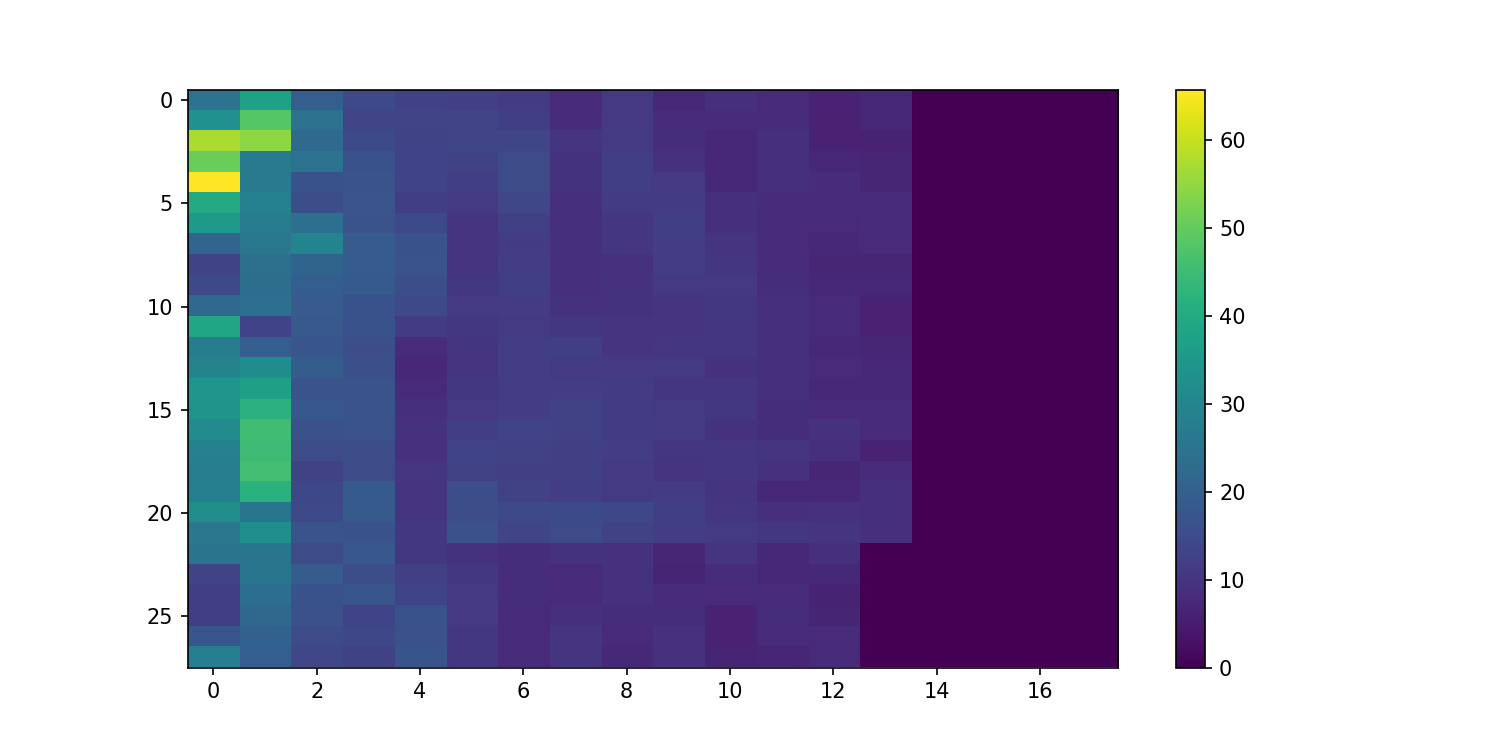

In [57]:
%matplotlib notebook
plt.figure(figsize=(10,5))
plt.imshow(two_d_array, aspect='auto')
# why is it so discontinuous 
# check spectra based on coordinates!!!!!!!!!!
plt.colorbar()

In [27]:
#v = np.array(final_chis_ewns)
#v.shape = (100,100)

print(v)
plt.figure()
#subtract off center shift from original q_ew and q_ns values
plt.imshow(v,vmax=2,extent=[y1[0]+ 0.000366718, y1[-1]+ 0.000366718, y1[0]-0.0012196, y1[-1]-0.0012196], origin='lower', cmap='plasma')
#plt.imshow(v, vmax=2, extent=[q_ns_min_new[0], q_ns_min_new[-1], q_ew_min_new[0], q_ew_min_new[-1]], origin='lower')
plt.xlabel('Range of Error in $Q_{ns}$')
plt.ylabel('Range of Error in $Q_{ew}$')
#plt.title('Difference in $\Chi^2$ for')
plt.colorbar()
plt.show()
#extent is the x and y values / axes
plt.imshow(np.log10(spectra_array[:,400:600]),vmin=-4,vmax=-0.6,cmap='magma',aspect='auto',interpolation= 'gaussian', extent=[freq[0],freq[-1],times[-1]-times[0],0]) #xfirst then y
plt.colorbar()

NameError: name 'final_chis_ewns' is not defined